In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [2]:
band5 = rasterio.open('LC08_L1TP_186024_20160630_20170323_01_T1/LC08_L1TP_186024_20160630_20170323_01_T1_B5.TIF')
band4 = rasterio.open('LC08_L1TP_186024_20160630_20170323_01_T1/LC08_L1TP_186024_20160630_20170323_01_T1_B4.TIF')

# NDVI calculation

## A. Calculate Reflectance values for each band

$ρλ' = M_{ρ} * Q_{cal} + A_{ρ}$

$ρλ'$ = TOA planetary reflectance, without correction for solar angle

$M_{ρ}$ = Band-specific multiplicative rescaling factor from the metadata (Reflectance_Mult_Band_x, where x is the band number)

$A_{ρ}$ = Band-specific additive rescaling factor from the metadata (Reflectance_Add_Band_x, where x is the band number)

$Q_{cal}$ = Quantized and calibrated standard product pixel values (DN).

## B. Apply a sun angle correction for each band

$ρλ = ρλ'/cos(θSZ) = ρλ'/sin(θSE)$

$ρλ$ = TOA planetary reflectance

$θSE$ = Local sun elevation angle. The scene center sun elevation angle in degrees is provided in the metadata (Sun Elevation).

$θSZ$ = Local solar zenith angle; $θSZ = 90° - θSE$. 

## C. Normalized Differential Vegetation Index

$NDVI = (NIR - RED) / (NIR + RED)$

$NIR$ = band 5 of Landsat 8

$RED$ = band 4 of Landsat 8

In [3]:
# A

a_rho = {4: 0, 5: 0}

file_address = 'LC08_L1TP_186024_20160630_20170323_01_T1/LC08_L1TP_186024_20160630_20170323_01_T1_MTL.txt'

def find_value(bands_numbers, mtl_file, indicator):
    values = []
    j = 0
    with open(mtl_file) as f:
        for line in f:
            for band in bands_numbers:
                if (indicator + str(band)) in line:
                    line = ''.join(line.split())
                    l = line.split('=')
                    values.append(float(l[1]))
                    j += 1
                elif j >= len(bands_numbers):
                    break
                else:
                    pass
    return dict(zip(bands_numbers, values))
                    
reflectances_mult = find_value([4, 5], file_address, 'REFLECTANCE_MULT_BAND_')
refletances_add = find_value([4, 5], file_address, 'REFLECTANCE_ADD_BAND_')

In [4]:
reflectances_mult

{4: 2e-05, 5: 2e-05}

In [5]:
refletances_add

{4: -0.1, 5: -0.1}

In [6]:
def calculate_reflectance(band, mult_factor, add_factor):
    r_band = band.read(1) * mult_factor + add_factor
    r_band[r_band > 1] = 0
    r_band[r_band < 0] = 0
    return r_band

b5_ref = calculate_reflectance(band5, reflectances_mult[5], refletances_add[5])
b4_ref = calculate_reflectance(band4, reflectances_mult[4], refletances_add[4])

In [7]:
# B

def calculate_sun_angle_correction(reflectance_band, mtl_file):
    sun_elevation_angle = 0
    indicator = 'SUN_ELEVATION'
    j = 0
    with open(mtl_file) as f:
        for line in f:
            if indicator in line:
                line = ''.join(line.split())
                l = line.split('=')
                sun_elevation_angle = float(l[1])
                j += 1
            elif j >= 1:
                break
            else:
                pass
    corrected_band = np.zeros(reflectance_band.shape)
    corrected_band = reflectance_band / np.sin(np.deg2rad(sun_elevation_angle))
    return corrected_band

b5_ref_corr = calculate_sun_angle_correction(b5_ref, file_address)
b4_ref_corr = calculate_sun_angle_correction(b4_ref, file_address)

In [8]:
# C

def ndvi(nir_band, red_band):
    ndvi_up = (nir_band - red_band)
    ndvi_down = (nir_band + red_band)
    ndvi = np.zeros(nir_band.shape)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = ndvi_up / ndvi_down
        ndvi = np.nan_to_num(ndvi)
    return ndvi

vegetation_index = ndvi(b5_ref_corr, b4_ref_corr)

Minimum and maximum value for vegetation index?

In [9]:
np.max(vegetation_index)

1.0

In [10]:
np.min(vegetation_index)

-1.0

<IPython.core.display.Javascript object>


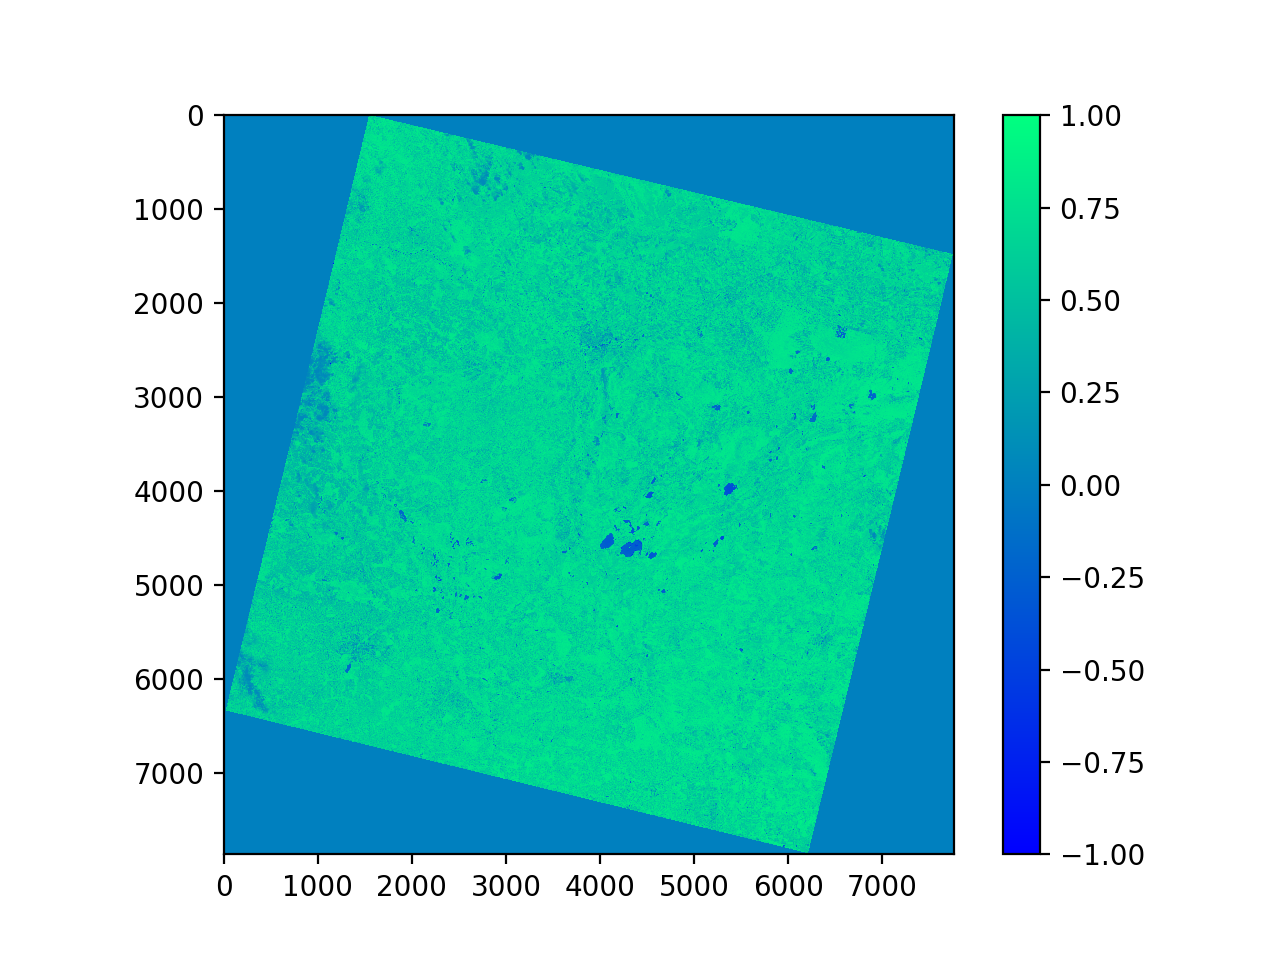

In [11]:
imgplot = plt.imshow(vegetation_index)
imgplot.set_cmap('winter')  # better color schemes: viridis, plasma, PRGn
plt.colorbar()

## End of the Notebook